Задача за DSCM006
=================

Предаваме като .ipynb в Moodle в курса DSCM006 до 15.02.2022 г.

In [90]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, LabelEncoder, Normalizer
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV, ParameterGrid
from sklearn.svm import SVC

import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [5]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [6]:
df_train = pd.read_csv('X_train.csv', encoding='ISO-8859-1')
df_test = pd.read_csv('X_test.csv', encoding='ISO-8859-1')

1.   Направете основен експлораторен анализ на обучителния набор;
2.   Намалете размерността на данните (PCA, correlation, VIF);
3.   Направете необходимите операции, за да присвоите на категорийните променливи числови стойности, така че те да могат да бъдат използвани в модел;
4.   Мащабирайте данните - необходимо е най-вече за SVM от моделите, които ще използвате;
5.   Използвайки кръстосана валидация с обучителния набор, намерете най-добрия модел, варирайки хиперпараметрите. Използвайте логистична регресия и метода на опорните вектори. Опитайте всички възможности за тези модели и чрез GridSearchCV или по друг начин намерете най-добрия модел като експериментирате с различни приложими метрики за оценка на точността;
6.   За SVM, scikit-learn предлага ядрата ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, които в т.5 се очаква да използвате в решението си. Освен тях, опитайте модел със сплайн ядро, което е описано [в доклад на Steve Gunn от 1998 г](http://www.svms.org/tutorials/Gunn1998.pdf). За начина на внедряване на код за ядра в sklearn можете да ползвате указанията по [тази](https://krypticmouse.hashnode.dev/training-svm-over-custom-kernels) връзка, а за реализация на сплайн ядро може да използвате [този](https://github.com/gmum/pykernels/blob/master/pykernels/regular.py) код. Ако намерите по-подходящи ядра, опитайте и с тях;
7.   *По желание.* Проучете как работи XGBoost и опитайте да решите задачата с него;
8.   След като сте избрали най-добрия модел, вижте как той се справя на тестовия набор. 

1. Основен експлораторен анализ

In [7]:
df_train.shape

(6591, 277)

In [8]:
df_test.shape

(2197, 277)

In [9]:
df_train["Bad_Flag"].value_counts(dropna=False)

0    5841
1     750
Name: Bad_Flag, dtype: int64

In [10]:
df_train.head()

,Unnamed: 0,Bad_Flag,x1,x2,x3,x4,x5,x6,x7,x8,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100,x101,x102,x103,x104,x105,x106,x107,x108,x109,x110,x111,x112,x113,x114,x115,x116,x117,x118,x119,x120,x121,x122,x123,x124,x125,x126,x127,x128,x129,x130,x131,x132,x133,x134,x135,x136,x137,x138,x139,x140,x141,x142,x143,x144,x145,x146,x147,x148,x149,x150,x151,x152,x153,x154,x155,x156,x157,x158,x159,x160,x161,x162,x163,x164,x165,x166,x167,x168,x169,x170,x171,x172,x173,x174,x175,x176,x177,x178,x179,x180,x181,x182,x183,x184,x185,x186,x187,x188,x189,x190,x191,x192,x193,x194,x195,x196,x197,x198,x199,x200,x201,x202,x203,x204,x205,x206,x207,x208,x209,x210,x211,x212,x213,x214,x215,x216,x217,x218,x219,x220,x221,x222,x223,x224,x225,x226,x227,x228,x229,x230,x231,x232,x233,x234,x235,x236,x237,x238,x239,x240,x241,x242,x243,x244,x245,x246,x247,x248,x249,x250,x251,x252,x253,x254,x255,x256,x257,x258,x259,x260,x261,x262,x263,x264,x265,x266,x267,x268,x269,x270,x271,x272,x273,x274,x275,x276
0,707,0,56,NoDPD,NoDPD,NoDPD,NoDPD,NoDPD,NoDPD,NoDPD,Never,Never,Never,Never,DPDCurrent,DPDCurrent,DPDCurrent,0,0,0,0,0,0.0,0.0,0.0,2428.33,0.00,0,0,963.02,0,0,0.00,1728.33,0.00,963.02,0.00,1728.33,0.00,167.61,0.00,0.0,0.00,2272.24,0.00,0.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,0.00,0.0,0.0,167.61,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,260.83,0.00,700.22,0.00,963.02,0.00,702.19,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,963.02,0.00,700.0,0,0.0,0.0,543.91,0.0,0.0,0,0.00,0,0,0,1663.24,0,0,0.00,0,0.0,963.02,0.00,700.22,0.00,0,0.0,0.0,963.02,0.00,0,0,0,0.000000,0,0,1.000000,0,0,0.000000,0.000000,0.557197,0.000000,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,1,0,0.000000,0.000000,0.0,Yes,20.80,2012.6800,2001.600,5,20.80,2012.6800,2001.600,5,ÐÐµÐ·ÑÑÐ¾ÑÐµÐ½ ÑÑÑÐ´Ð¾Ð² Ð´Ð¾Ð³Ð¾Ð²Ð¾Ñ,01,Yes,1,1,807.877778,799.0,72332009,4910,0.0,0.0,0.0,1.0,7,364,72,364,4,364,49,364,1,1,812.316667,799.0,72332009,4910,0.0,0.0,0.0,1.0,7,183,72,183,4,183,49,183,1,1,807.877778,799.0,72332009,4910,0.0,0.0,0.0,1.0,7,91,72,91,4,91,49,91,133,377,3,Yes,0.0,NaN,Missing,0.0,0.0,0,Missing,Missing,No,2428.33,0.00,2428.33,963.02,0.00,963.02,0.00,0.00,0.00,0.00,Íå,Äà,Íå,Äà
1,5740,1,21,NoDPD,NoDPD,NoDPD,NoDPD,NoDPD,NoDPD,NoDPD,Never,Never,Never,Never,DPDCurrent,DPDCurrent,DPDCurrent,0,0,0,0,0,0.0,0.0,0.0,0.00,2300.00,0,0,0.00,0,0,1277.27,0.00,800.00,0.00,777.27,0.00,800.00,0.00,169.23,0.0,0.00,0.00,1800.00,0.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,0.00,0.0,0.0,0.00,169.23,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,856.27,0.00,1277.27,0.00,1277.27,0.0,1500.0,0.0,500.0,0.0,1000.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,1152.68,0.0,0,0.0,0.0,0.00,0.0,0.0,0,0.00,0,0,0,0.00,0,0,2133.54,0,0.0,0.00,1277.27,0.00,856.27,0,0.0,0.0,0.00,1152.68,0,0,0,1.000000,0,0,0.000000,0,0,1.000000,1.000000,0.000000,0.971588,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000000,0,5,0.000000,0.000000,0.0,Yes,0.00,0.0000,0.000,0,0.00,0.0000,0.000,0,Missing,Missing,No,0,0,0.000000,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0.000000,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0.000000,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,No,0.0,NaN,Missing,0.0,0.0,0,Missing,Missing,No,0.00,2300.00,2300.00,0.00,1277.27,1277.27,777.27,0.00,0.00,0.00,Äà,Íå,Íå,Íå
2,6646,0,31,NoDPD,NoDPD,NoDPD,NoDPD,NoDPD,NoDPD,NoDPD,Never,Never,Never,Never,DPDCurrent,DPDCurrent,DPDCurrent,0,0,0,0,0,0.0,0.0,0.0,8500.00,29469.17,0,0,8220.00,0,0,27234.56,7000.00,29469.17,6826.00,27234.56,7000.00,29469.32,104.49,497.93,0.0,122.11,8473.00,29469.32,0.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,0.00,0.0,0.0,134.49,497.93,7742.0,27234.56,0.0,0.0,35.36,122.11

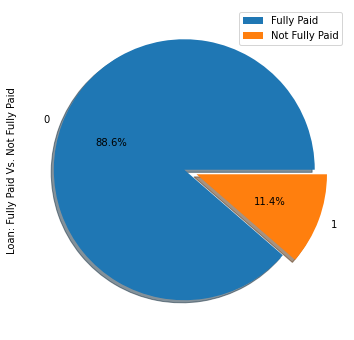

In [11]:
# Helper function for data distribution
# Visualize the proportion of borrowers
def show_loan_distrib(data):
  count = ""
  if isinstance(data, pd.DataFrame):
      count = data["Bad_Flag"].value_counts()
  else:
      count = data.value_counts()


  count.plot(kind = 'pie', explode = [0, 0.1], 

              figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
  plt.ylabel("Loan: Fully Paid Vs. Not Fully Paid")
  plt.legend(["Fully Paid", "Not Fully Paid"])
  plt.show()


# Visualize the proportion of borrowers
show_loan_distrib(df_train)

Можем да видим, че таргет променливата ни е небансирана.  

In [9]:
print(df_train.dtypes)

Unnamed: 0      int64
Bad_Flag        int64
x1              int64
x2             object
x3             object
x4             object
x5             object
x6             object
x7             object
x8             object
x10            object
x11            object
x12            object
x13            object
x14            object
x15            object
x16            object
x17             int64
x18             int64
x19             int64
x20             int64
x21             int64
x22           float64
x23           float64
x24           float64
x25           float64
x26           float64
x27             int64
x28             int64
x29           float64
x30             int64
x31             int64
x32           float64
x33           float64
x34           float64
x35           float64
x36           float64
x37           float64
x38           float64
x39           float64
x40           float64
x41           float64
x42           float64
x43           float64
x44           float64
x45       

In [10]:
df_train.describe()

,Unnamed: 0,Bad_Flag,x1,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100,x101,x102,x103,x104,x105,x106,x107,x108,x109,x110,x111,x112,x113,x114,x115,x116,x117,x118,x119,x120,x121,x122,x123,x124,x125,x126,x127,x128,x129,x130,x131,x132,x133,x134,x135,x136,x137,x138,x139,x140,x141,x142,x143,x144,x145,x146,x147,x148,x149,x150,x151,x152,x153,x154,x155,x156,x157,x158,x159,x160,x161,x162,x163,x164,x165,x166,x167,x168,x169,x170,x171,x172,x173,x174,x175,x176,x177,x178,x179,x180,x181,x182,x183,x185,x186,x187,x188,x189,x190,x191,x192,x196,x197,x198,x199,x200,x201,x202,x203,x204,x205,x206,x207,x208,x209,x210,x211,x212,x213,x214,x215,x216,x217,x218,x219,x220,x221,x222,x223,x224,x225,x226,x227,x228,x229,x230,x231,x232,x233,x234,x235,x236,x237,x238,x239,x240,x241,x242,x243,x244,x245,x246,x247,x248,x249,x250,x251,x252,x254,x257,x258,x259,x263,x264,x265,x266,x267,x268,x269,x270,x271,x272
count,6591.000000,6591.000000,6591.000000,6591.0,6591.0,6591.0,6591.0,6591.0,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.0,6591.0,6591.000000,6591.0,6591.0,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.0,6591.000000,6591.0,6591.0,6591.0,6591.0,6591.0,6591.0,6591.000000,6591.0,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6.591000e+03,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.00000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.0,6591.0,6591.0,6591.000000,6591.0,6591.0,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.0,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.0,6591.0,6591.000000,6591.0,6591.0,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.00000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.0,6591.0,6591.0,6591.0,6591.0,6591.0,6591.0,6591.0,6591.0,6591.000000,6591.0,6591.000000,6591.0,6591.000000,6591.0,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6.591000e+03,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6.591000e+03,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6.591000e+03,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000,6591.000000
mean,4404.311182,0.113792,41

In [11]:
df_train.isna().sum()

Unnamed: 0       0
Bad_Flag         0
x1               0
x2               0
x3               0
x4               0
x5               0
x6               0
x7               0
x8               0
x10              0
x11              0
x12              0
x13              0
x14              0
x15              0
x16              0
x17              0
x18              0
x19              0
x20              0
x21              0
x22              0
x23              0
x24              0
x25              0
x26              0
x27              0
x28              0
x29              0
x30              0
x31              0
x32              0
x33              0
x34              0
x35              0
x36              0
x37              0
x38              0
x39              0
x40              0
x41              0
x42              0
x43              0
x44              0
x45              0
x46              0
x47              0
x48              0
x49              0
x50              0
x51              0
x52         

In [12]:
df_train[~df_train["x255"].isna()]["x255"].head()

5     2016-12-17
10    2016-05-09
16    2000-03-27
22    2019-10-22
28    2008-02-29
Name: x255, dtype: object

Поглеждайки бройките липсващи стойности на всяка колона, виждаме, че променлива х255 има висок процент липсващи стойности. След допълнителна проверка, откриваме, че е дата. Размерът на липсващите в х255 е различен от обзервациите с Bad_Flag = 1, което означава, че х255 не е датата, на която обзервациите стават "Bad". Следователно, можем да дропнем променливата.

In [13]:
df_train = df_train.drop("x255", axis='columns')
df_test = df_test.drop("x255", axis='columns')

Премахваме променливи, които имат само 1 оригинална стойност

In [14]:
# Check for vars with only 1 value
vars_to_remove = list(df_train.columns[df_train.nunique() <= 1])

In [15]:
df_train = df_train.drop(vars_to_remove, axis='columns')
df_test = df_test.drop(vars_to_remove, axis='columns')

Преглеждаме променливи от тип string

In [16]:
df_num = df_train.select_dtypes(exclude=[np.number])

In [17]:
df_num.select_dtypes('object').describe()

,x2,x3,x4,x5,x6,x7,x8,x10,x11,x12,x13,x193,x194,x195,x253,x256,x260,x261,x262,x273,x274,x275,x276
count,6591,6591,6591,6591,6591,6591,6591,6591,6591,6591,6591,6591,6591,6591,6591,6591,6591,6591,6591,6591,6591,6591,6591
unique,4,4,4,4,2,3,2,3,3,3,3,11,21,2,2,3,3,3,2,2,2,2,2
top,NoDPD,NoDPD,NoDPD,NoDPD,NoDPD,NoDPD,NoDPD,Never,Never,Never,Never,ÐÐµÐ·ÑÑÐ¾ÑÐµÐ½ ÑÑÑÐ´Ð¾Ð² Ð´Ð¾Ð³Ð¾Ð²Ð¾Ñ,01,Yes,Yes,Missing,Missing,Missing,No,Äà,Äà,Íå,Íå
freq,5557,4806,6362,4576,6588,6588,6586,5557,4806,6362,4576,3870,3690,5038,4377,6046,6046,6046,6046,3524,4226,6189,3449


In [18]:
for i in range(df_num.shape[1]):
    print(df_num.iloc[:, i].value_counts(dropna=False))

NoDPD     5557
DPD90      768
DPD180     158
DPD181     108
Name: x2, dtype: int64
NoDPD     4806
DPD90      912
DPD181     577
DPD180     296
Name: x3, dtype: int64
NoDPD     6362
DPD90      207
DPD180      14
DPD181       8
Name: x4, dtype: int64
NoDPD     4576
DPD181     902
DPD90      860
DPD180     253
Name: x5, dtype: int64
NoDPD    6588
DPD90       3
Name: x6, dtype: int64
NoDPD     6588
DPD90        2
DPD181       1
Name: x7, dtype: int64
NoDPD    6586
DPD90       5
Name: x8, dtype: int64
Never      5557
More24M    1031
Less24M       3
Name: x10, dtype: int64
Never      4806
More24M    1782
Less24M       3
Name: x11, dtype: int64
Never      6362
More24M     224
Less24M       5
Name: x12, dtype: int64
Never      4576
More24M    2011
Less24M       4
Name: x13, dtype: int64
ÐÐµÐ·ÑÑÐ¾ÑÐµÐ½ ÑÑÑÐ´Ð¾Ð² Ð´Ð¾Ð³Ð¾Ð²Ð¾Ñ    3870
Missing                                           1553
Ð¡Ð°Ð¼Ð¾Ð¾ÑÐ¸Ð³ÑÑÑÐ²Ð°Ñ ÑÐµ                  323
Unemployed                                   

Оправяме стойностите в х193, за четимост

In [19]:
df_train["x193"] = np.where(df_train["x193"] == "Ð\x91ÐµÐ·Ñ\x81Ñ\x80Ð¾Ñ\x87ÐµÐ½ Ñ\x82Ñ\x80Ñ\x83Ð´Ð¾Ð² Ð´Ð¾Ð³Ð¾Ð²Ð¾Ñ\x80", "Безсрочен трудов договор", 
                        np.where(df_train["x193"] == "Ð¡Ð°Ð¼Ð¾Ð¾Ñ\x81Ð¸Ð³Ñ\x83Ñ\x80Ñ\x8fÐ²Ð°Ñ\x89 Ñ\x81Ðµ", "Самоосигуряващ се", 
                            np.where(df_train["x193"] == "Ð\x92Ð¾ÐµÐ½Ð½Ð¾Ñ\x81Ð»Ñ\x83Ð¶ÐµÑ\x89", "Военнослужещ", 
                                np.where(df_train["x193"] == "Ð\x91ÐµÐ·Ñ\x80Ð°Ð±Ð¾Ñ\x82ÐµÐ½ Ð½Ð° Ñ\x81Ð¾Ñ\x86. Ð¿Ð¾Ð¼Ð¾Ñ\x89Ð¸", "Безработен на соц. помощи", 
                                    np.where(df_train["x193"] == "Ð\x94Ñ\x80Ñ\x83Ð³Ð¾", "Друго", 
                                        np.where(df_train["x193"] == "Ð\x94Ð¾Ð³Ð¾Ð²Ð¾Ñ\x80 Ð·Ð° Ñ\x83Ð¿Ñ\x80Ð°Ð²Ð»ÐµÐ½Ð¸Ðµ", "Договор за управление", 
                                            np.where(df_train["x193"] == "Ð\x94Ñ\x8aÑ\x80Ð¶Ð°Ð²ÐµÐ½ Ñ\x81Ð»Ñ\x83Ð¶Ð¸Ñ\x82ÐµÐ»", "Държавен служител", 
                                                np.where(df_train["x193"] == "Äîïúëíèòåëåí òðóäîâ äîãîâîð", "Unknown 1", 
                                                    np.where(df_train["x193"] == "Ñúäèÿ/ïðîêóðîð", "Unknown 2", df_train["x193"])))))))))

In [20]:
df_test["x193"] = np.where(df_test["x193"] == "Ð\x91ÐµÐ·Ñ\x81Ñ\x80Ð¾Ñ\x87ÐµÐ½ Ñ\x82Ñ\x80Ñ\x83Ð´Ð¾Ð² Ð´Ð¾Ð³Ð¾Ð²Ð¾Ñ\x80", "Безсрочен трудов договор", 
                        np.where(df_test["x193"] == "Ð¡Ð°Ð¼Ð¾Ð¾Ñ\x81Ð¸Ð³Ñ\x83Ñ\x80Ñ\x8fÐ²Ð°Ñ\x89 Ñ\x81Ðµ", "Самоосигуряващ се", 
                            np.where(df_test["x193"] == "Ð\x92Ð¾ÐµÐ½Ð½Ð¾Ñ\x81Ð»Ñ\x83Ð¶ÐµÑ\x89", "Военнослужещ", 
                                np.where(df_test["x193"] == "Ð\x91ÐµÐ·Ñ\x80Ð°Ð±Ð¾Ñ\x82ÐµÐ½ Ð½Ð° Ñ\x81Ð¾Ñ\x86. Ð¿Ð¾Ð¼Ð¾Ñ\x89Ð¸", "Безработен на соц. помощи", 
                                    np.where(df_test["x193"] == "Ð\x94Ñ\x80Ñ\x83Ð³Ð¾", "Друго", 
                                        np.where(df_test["x193"] == "Ð\x94Ð¾Ð³Ð¾Ð²Ð¾Ñ\x80 Ð·Ð° Ñ\x83Ð¿Ñ\x80Ð°Ð²Ð»ÐµÐ½Ð¸Ðµ", "Договор за управление", 
                                            np.where(df_test["x193"] == "Ð\x94Ñ\x8aÑ\x80Ð¶Ð°Ð²ÐµÐ½ Ñ\x81Ð»Ñ\x83Ð¶Ð¸Ñ\x82ÐµÐ»", "Държавен служител", 
                                                np.where(df_test["x193"] == "Äîïúëíèòåëåí òðóäîâ äîãîâîð", "Unknown 1", 
                                                    np.where(df_test["x193"] == "Ñúäèÿ/ïðîêóðîð", "Unknown 2", df_test["x193"])))))))))

In [21]:
df_train["x193"].value_counts(dropna=False)

Безсрочен трудов договор     3870
Missing                      1553
Самоосигуряващ се             323
Unemployed                    284
Друго                         269
Безработен на соц. помощи     104
Военнослужещ                  104
Държавен служител              36
Договор за управление          19
Unknown 1                      18
Unknown 2                      11
Name: x193, dtype: int64

Виждаме, че пандас има затруднения с четенето на български език. Опитах да променя енкодинг, но нямах успех. Допълнитено, много от променливите имат много висок % струпвания в една стойност и взимаме решение да ги премахнем. 

In [22]:
vars_to_remove = ["x5", "x6", "x7"]

In [23]:
df_train = df_train.drop(vars_to_remove, axis='columns')
df_test = df_test.drop(vars_to_remove, axis='columns')

Превръщане стринг променливи в нумерични, използвайки pd.get_dummies. Защото в df_test имаме по-малко данни и липсват някои стойности, които може да има в df_train, ние ги добавяме със стойност нула.

In [24]:
df_num = df_train.select_dtypes(exclude=[np.number])

In [25]:
df_train = pd.get_dummies(data=df_train, columns=list(df_num.columns))
df_test = pd.get_dummies(data=df_test, columns=list(df_num.columns))

In [26]:
print(df_train.shape)
print(df_test.shape)

(6591, 291)
(2197, 287)


In [27]:
df_train, df_test = df_train.align(df_test, join='outer', axis=1, fill_value=0)

2. Намаляване на размерността на данните

In [28]:
x_train = df_train.drop("Bad_Flag", axis='columns').copy()
y_train = df_train[["Bad_Flag"]].copy()

x_test = df_test.drop("Bad_Flag", axis='columns').copy()
y_test = df_test[["Bad_Flag"]].copy()

In [29]:
std_scaler = StandardScaler()
x_train = std_scaler.fit_transform(x_train)
x_test = std_scaler.transform(x_test)

In [30]:
nums = [10, 20, 30, 50, 100, 150, 200, 250, 275, 290]

In [31]:
var_ratio = []
for num in nums:
  pca = PCA(n_components=num)
  pca.fit(x_train)
  var_ratio.append(np.sum(pca.explained_variance_ratio_))

Text(0.5, 1.0, 'n_components vs. Explained Variance Ratio')

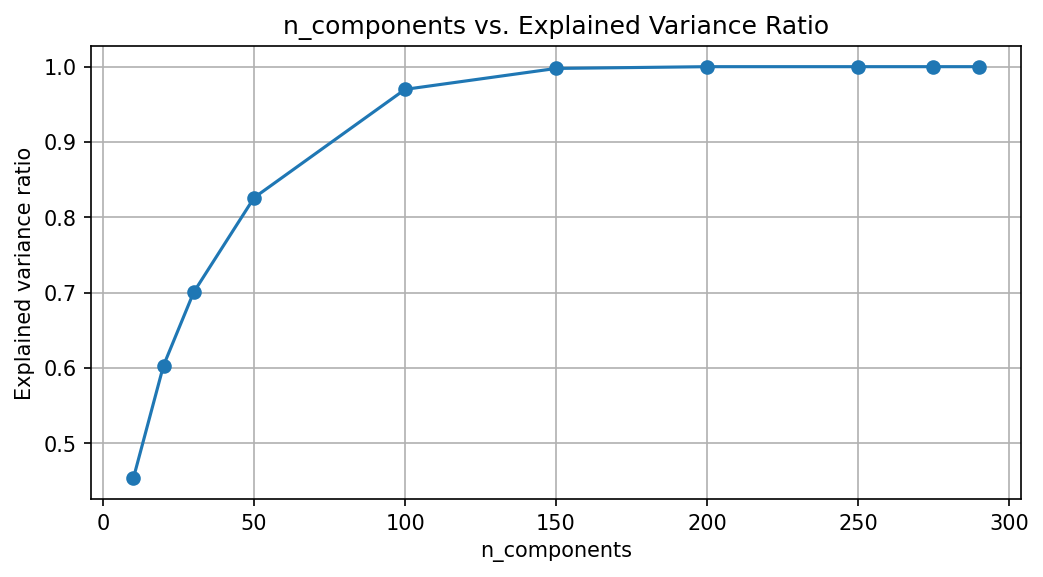

In [32]:
plt.figure(figsize=(8,4),dpi=150)
plt.grid()
plt.plot(nums,var_ratio,marker='o')
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.title('n_components vs. Explained Variance Ratio')

Можем да видим от графиката, че при използване на 150 променвили, не губим информация, а при 100 променливи губим около 3%. В този случай, ще изберем 100 n_components, за следващите стъпки.

In [33]:
pca = PCA(n_components=150)
pca_features = pca.fit_transform(x_train)

In [34]:
print(sum(pca.explained_variance_ratio_))

0.9976481815166865


In [35]:
# Show PCA characteristics
print('Shape before PCA: ', x_train.shape)
print('Shape after PCA: ', pca_features.shape)

Shape before PCA:  (6591, 290)
Shape after PCA:  (6591, 150)


In [36]:
pca_test = PCA(n_components=150)
pca_features_test = pca_test.fit_transform(x_test)

In [37]:
print(sum(pca_test.explained_variance_ratio_))

0.9993243447863547


In [38]:
# Show PCA characteristics
print('Shape before PCA: ', x_test.shape)
print('Shape after PCA: ', pca_features_test.shape)

Shape before PCA:  (2197, 290)
Shape after PCA:  (2197, 150)


5. Логистична регресия

In [52]:
def gini(x):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [44]:
cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

In [37]:
params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 10000],
          'penalty': ['l1', 'l2'],
          'solver': ['liblinear', 'saga']}

grid_search = GridSearchCV(LogisticRegression(max_iter = 2000), params, scoring='f1', cv=cv)

In [38]:
grid_search.fit(pca_features, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=LogisticRegression(max_iter=2000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 10000],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='f1')

In [44]:
grid_search.best_estimator_

LogisticRegression(C=1, max_iter=2000, solver='saga')

In [56]:
grid_search.best_estimator_.penalty

'l2'

In [ ]:
best_model = grid_search.best_estimator_

In [100]:
# Set params for best model from grid search
lr_clf = LogisticRegression().set_params(C=1, max_iter=2000, solver="saga", penalty="l2")
lr_clf.fit(pca_features, y_train)


LogisticRegression(C=1, max_iter=2000, solver='saga')

In [101]:
y_pred = lr_clf.predict(pca_features_test)
print('The AUC score of the best Logistic Regression model is ', roc_auc_score(y_test, y_pred))
print('The Accuracy of the best Logistic Regression model is ', lr_clf.score(pca_features_test, y_test))

The AUC score of the best Logistic Regression model is  0.4939301489470981
The Accuracy of the best Logistic Regression model is  0.8661811561219845


In [102]:
# Gini coefficient for Logistic Regression
print("Gini coefficient for Logistic Regression: " + str(gini(y_pred)))

Gini coefficient for Logistic Regression: 0.9772416932180247


In [103]:
confusion_matrix(y_test, y_pred)

array([[1900,   47],
       [ 247,    3]])

In [104]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93      1947
           1       0.06      0.01      0.02       250

    accuracy                           0.87      2197
   macro avg       0.47      0.49      0.47      2197
weighted avg       0.79      0.87      0.82      2197



Support Vector Machines

In [45]:
params = {'C': [0.1, 1, 10, 100, 1000],
          'gamma': [1, 0.1 ,0.01, 0.001, 0.0001, "scale"],
          'kernel': ['rbf', 'poly', 'linear', 'sigmoid']}

grid_search = GridSearchCV(SVC(), params, scoring='roc_auc', cv=cv)

In [ ]:
grid_search.fit(pca_features, y_train)

In [ ]:
grid_search.best_estimator_

In [ ]:
grid_search.best_estimator_.kernel

In [ ]:
best_model = grid_search.best_estimator_

In [95]:
# Set params for best model from grid search
svc_clf = SVC().set_params(C=0.1, gamma="scale", kernel="sigmoid")
svc_clf.fit(pca_features, y_train)

SVC(C=0.1, kernel='sigmoid')

In [96]:
y_pred = svc_clf.predict(pca_features_test)
print('The AUC score of the best SVM is ', roc_auc_score(y_test, y_pred))
print('The Accuracy of the best SVM is ', svc_clf.score(pca_features_test, y_test))

The AUC score of the best SVM is  0.5009727786337956
The Accuracy of the best SVM is  0.8848429676832044


In [97]:
# Gini coefficient for SVC
print("Gini coefficient for SVC: " + str(gini(y_pred)))

Gini coefficient for SVC: 0.9977241693218026


In [98]:
# Confusion matrix
confusion_matrix(y_test, y_pred)

array([[1943,    4],
       [ 249,    1]])

In [99]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1947
           1       0.20      0.00      0.01       250

    accuracy                           0.88      2197
   macro avg       0.54      0.50      0.47      2197
weighted avg       0.81      0.88      0.83      2197



От резултатите можем да видим, че Support Vector Machines се справят по-добре от Logistic Regression. От друга страна, Намирането на най-добрите хиперпараметри за логистичната регресия отне няколко часа, за опорните вектори отне няколко дни на различни лаптопи.

6. Сплайн ядро на Steve Gunn

In [66]:
def spline(data_1, data_2):

    kernel = np.ones((data_1.shape[0], data_2.shape[0]))

    for d in range(data_1.shape[1]):
        column_1 = data_1[:, d].reshape(-1, 1)
        column_2 = data_2[:, d].reshape(-1, 1)
        c_prod = column_1 * column_2.T
        c_sum = column_1 + column_2.T
        c_min = np.minimum(column_1, column_2.T)
        kernel *= 1. + c_prod + c_prod * c_min \
                        - c_sum/2. * c_min ** 2. \
                         + 1./3. * c_min ** 3.
    return kernel

In [69]:
# Additional normalization of the data
transformer = Normalizer().fit(pca_features)
transformer = transformer.transform(pca_features)

transformer_test = Normalizer().fit(pca_features_test)
transformer_test = transformer_test.transform(pca_features_test)

In [92]:
# Set params for best model from grid search with the Spline kernel
svc_clf_spline = SVC().set_params(C=0.1, gamma="scale", kernel="sigmoid")
svc_clf_spline.fit(transformer, y_train)

y_pred = svc_clf_spline.predict(transformer_test)
print('The AUC score of the best SVM is ', roc_auc_score(y_test, y_pred))
print('The Accuracy of the best SVM is ', svc_clf_spline.score(transformer_test, y_test))

The AUC score of the best SVM is  0.5
The Accuracy of the best SVM is  0.8862084660901229


In [93]:
# Confusion matrix
confusion_matrix(y_test, y_pred)

array([[1947,    0],
       [ 250,    0]])

In [94]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1947
           1       0.00      0.00      0.00       250

    accuracy                           0.89      2197
   macro avg       0.44      0.50      0.47      2197
weighted avg       0.79      0.89      0.83      2197



7. XG Boost with HyperOpt hyperparameter optimization

In [73]:
# Setting params space 
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [74]:
# Setting model, evaluation and scoring methods
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))

    evaluation = [( x_train, y_train), ( x_test, y_test)]

    clf.fit(x_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)


    pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK, 'model': clf }

In [77]:
# The actual search for the optimal parameters happens here
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:
0.8862084660901229
SCORE:
0.8862084660901229
SCORE:
0.8862084660901229
SCORE:
0.8862084660901229
SCORE:
0.8862084660901229
SCORE:
0.8862084660901229
SCORE:
0.8862084660901229
SCORE:
0.8862084660901229
SCORE:
0.8862084660901229
SCORE:
0.8862084660901229
SCORE:
0.8862084660901229
SCORE:
0.8862084660901229
SCORE:
0.8862084660901229
SCORE:
0.8862084660901229
SCORE:
0.8862084660901229
SCORE:
0.8862084660901229
SCORE:
0.8862084660901229
SCORE:
0.8862084660901229
SCORE:
0.8862084660901229
SCORE:
0.8862084660901229
SCORE:
0.8862084660901229
SCORE:
0.8862084660901229
SCORE:
0.8862084660901229
SCORE:
0.8862084660901229
SCORE:
0.8862084660901229
SCORE:
0.8862084660901229
SCORE:
0.8862084660901229
SCORE:
0.8862084660901229
SCORE:
0.8862084660901229
SCORE:
0.8862084660901229
SCORE:
0.8862084660901229
SCORE:
0.8862084660901229
SCORE:
0.8862084660901229
SCORE:
0.8862084660901229
SCORE:
0.8862084660901229
SCORE:
0.8862084660901229
SCORE:
0.8862084660901229
SCORE:
0.8862084660901229
SCORE:
0.886

In [89]:
print("The best hyperparameters for XGBoost are: ","\n")
print(best_hyperparams)

The best hyperparameters for XGBoost are:  

{'colsample_bytree': 0.7062392936824688, 'gamma': 7.302307693635425, 'max_depth': 17.0, 'min_child_weight': 7.0, 'reg_alpha': 154.0, 'reg_lambda': 0.39683469993235077}


In [80]:
# Save the best model
clf_xg = trials.results[np.argmin([r['loss'] for r in trials.results])]['model']

In [81]:
y_pred = clf_xg.predict(x_test)
print('The AUC score of the best XG Classifier with normal data is ',roc_auc_score(y_test, y_pred))
print('The Accuracy of the best XG Classifier with normal data is ', clf_xg.score(x_test, y_test))

The AUC score of the best XG Classifier with normal data is  0.5
The Accuracy of the best XG Classifier with normal data is  0.8862084660901229


In [83]:
# Confusion matrix
confusion_matrix(y_test, y_pred)

array([[1947,    0],
       [ 250,    0]])

In [91]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1947
           1       0.00      0.00      0.00       250

    accuracy                           0.89      2197
   macro avg       0.44      0.50      0.47      2197
weighted avg       0.79      0.89      0.83      2197



In conclusion, the confusion matrix and the other report show that the models largely overfitt, ergo, the imbalance in the predictions, mostly being TP (True Positive) and FP (False Positive). We can see the the XGBoost and the SVC with Spline predict only Positive values, while sigmoid SVC and LR predict just a few negatives.